In [1]:
prediction_data = '/work/lpdi/users/khakzad/Surfacome/database/dataset_surfaces.pt'
pdb_data = '/work/lpdi/users/khakzad/Surfacome/pdbs/target_list_1_chopped/'
pointcloud_results = '/work/lpdi/users/khakzad/Surfacome/pdbs/target_list_1_pointcloud/'

In [2]:
import nglview as ng
import ipywidgets as widgets
import numpy as np
import torch
import os
import trimesh
from nglview.color import ColormakerRegistry
from pdbparser.pdbparser import pdbparser

# Loading the data and check some basics

In [3]:
data = torch.load(prediction_data, map_location=torch.device('cpu'))
##data = torch.load(prediction_data, map_location={'cuda:1':'cuda:0'})

In [8]:
acc = []
coords = []
embeddings = []
normals = []
labels = []
for i, item in enumerate(data):
    print (i, item)
    acc.append(item['acc'])
    coords.append(item['coords'])
    embeddings.append(item['embeddings'])
    normals.append(item['normals'])
    labels.append(item['label'])

print(len(acc), len(coords), len(embeddings), len(labels))

0 {'acc': 'P26992', 'coords': tensor([[-49.6303,  19.2350,  22.7692],
        [-49.6385,  19.7786,  21.8943],
        [-49.7666,  19.7112,  22.6260],
        ...,
        [ 38.8486,  24.1296, -31.5061],
        [ 38.8080,  24.2806, -30.4623],
        [ 38.6975,  24.2738, -29.8300]]), 'normals': tensor([[-0.8223, -0.5589, -0.1070],
        [-0.9459, -0.1385, -0.2934],
        [-0.9563, -0.1961, -0.2168],
        ...,
        [ 0.7938,  0.6036, -0.0745],
        [ 0.8992,  0.4367,  0.0265],
        [ 0.8885,  0.3464,  0.3010]]), 'embeddings': tensor([[-0.3718,  1.2455,  0.0602,  ..., -0.3293,  0.6986,  0.2535],
        [-0.4764,  1.4100, -0.0411,  ..., -0.1709,  0.6857,  0.4162],
        [-0.3169,  1.4424, -0.0726,  ..., -0.2176,  0.6812,  0.3761],
        ...,
        [-0.2658,  0.4453,  0.7507,  ..., -0.9364,  0.3328, -0.5212],
        [-0.2652,  0.4652,  0.7811,  ..., -0.9945,  0.2194, -0.5849],
        [-0.2928,  0.4473,  0.8280,  ..., -0.7691,  0.3202, -0.5770]]), 'label': tensor([[

In [5]:
## First entry:
print(acc[0], coords[0], embeddings[0], labels[0], normals[0])
print(acc[0], len(coords[0]), len(embeddings[0]), len(labels[0]), len(normals[0]))


P26992 tensor([[-49.6303,  19.2350,  22.7692],
        [-49.6385,  19.7786,  21.8943],
        [-49.7666,  19.7112,  22.6260],
        ...,
        [ 38.8486,  24.1296, -31.5061],
        [ 38.8080,  24.2806, -30.4623],
        [ 38.6975,  24.2738, -29.8300]]) tensor([[-0.3718,  1.2455,  0.0602,  ..., -0.3293,  0.6986,  0.2535],
        [-0.4764,  1.4100, -0.0411,  ..., -0.1709,  0.6857,  0.4162],
        [-0.3169,  1.4424, -0.0726,  ..., -0.2176,  0.6812,  0.3761],
        ...,
        [-0.2658,  0.4453,  0.7507,  ..., -0.9364,  0.3328, -0.5212],
        [-0.2652,  0.4652,  0.7811,  ..., -0.9945,  0.2194, -0.5849],
        [-0.2928,  0.4473,  0.8280,  ..., -0.7691,  0.3202, -0.5770]]) tensor([[0.1938],
        [0.1915],
        [0.1753],
        ...,
        [0.3355],
        [0.3605],
        [0.3825]]) tensor([[-0.8223, -0.5589, -0.1070],
        [-0.9459, -0.1385, -0.2934],
        [-0.9563, -0.1961, -0.2168],
        ...,
        [ 0.7938,  0.6036, -0.0745],
        [ 0.8992,  0.4

### Representing the data in nglview

In [5]:
def show_pointcloud(main_pdb, coord_file, labels_file):
    # Normalize embedding to represent a b-factor value between 0-100
    b_factor = []
    for emb in labels_file:
        b_factor.append(emb)
    
    # writing a psudo pdb of all points using their coordinates and H atom.
    records = []

    for i in range(len(coord_file)):
        points = coord_file[i]
        x_coord = points[0]
        y_coord = points[1]
        z_coord = points[2]

        records.append( { "record_name"       : 'ATOM',
                    "serial_number"     : len(records)+1,
                    "atom_name"         : 'H',
                    "location_indicator": '',
                    "residue_name"      : 'XYZ',
                    "chain_identifier"  : '',
                    "sequence_number"   : len(records)+1,
                    "code_of_insertion" : '',
                    "coordinates_x"     : x_coord,
                    "coordinates_y"     : y_coord,
                    "coordinates_z"     : z_coord,
                    "occupancy"         : 1.0,
                    "temperature_factor": b_factor[i]*100,
                    "segment_identifier": '',
                    "element_symbol"    : 'H',
                    "charge"            : '',
                    } )

    pdb = pdbparser()
    pdb.records = records

    pdb.export_pdb("pointcloud.pdb")

    # reading the psudo PDB we generated above for the point cloud.
    coordPDB = "pointcloud.pdb"
    view = ng.NGLWidget()
    view.add_component(coordPDB, defaultRepresentation=False)

    # representation with our customized colorscheme.
    view.add_representation('point', 
                          useTexture = 1,
                          pointSize = 4,
                          colorScheme = "bfactor",
                          colorDomain = [100.0, 0.0], 
                          colorScale = 'rwb',
                          selection='_H')

    #   view.add_component(ng.FileStructure(os.path.join("/content", main_pdb)))
    view.add_component(main_pdb)
    view.background = 'white'
    return view

def show_structure(main_pdb):
    # reading the psudo PDB we generated above for the point cloud.
    view = ng.NGLWidget()

    view.add_component(ng.FileStructure(main_pdb), defaultRepresentation=False)
    view.add_representation("cartoon", colorScheme = "bfactor", colorScale = 'rwb', colorDomain = [100.0, 0.0])
    view.add_representation("ball+stick", colorScheme = "bfactor", colorScale = 'rwb', colorDomain = [100.0, 0.0])
    view.background = 'black'
    return view

In [10]:
num = 91
print(acc[num])
target_pdb = os.path.join(pdb_data,acc[num]+"_cropped.pdb")
coord = coords[num]
label = labels[num]
normal = normals[num]

view = show_pointcloud(target_pdb, coord, label)
view

Q13002
2023-03-07 14:50:35 - pdbparser <INFO> All records successfully exported to 'pointcloud.pdb'


NGLWidget()

# Extracting the sequence for the input protein

In [8]:
from Bio import *
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1

p = PDBParser()
structure = p.get_structure("PDB0", target_pdb)
model = structure[0]

seq_list = []
for chain in model:
    for residue in chain:
        correct_res_type1 = residue['CA']
        seq_list.append(residue.resname)
        
print("".join(seq_list))

GLYTHRTRPLEULEUALACYSILECYSILEARGTHRPHETHRCYSLEUTHRASNASNILELEUARGILEASPCYSHISTRPSERALAPROGLULEUGLYSERSERPROTRPLEULEUPHETHRSERASNGLNALAPROGLYGLYTHRHISLYSCYSILELEUARGGLYSERGLUCYSTHRVALVALLEUPROPROGLUALAVALLEUVALPROSERASPASNPHETHRILETHRPHEHISHISCYSMETSERGLYARGGLUGLNVALSERLEUVALASPPROGLUTYRLEUPROARGARGHISVALLYSLEUASPPROPROSERASPLEUGLNSERASNILESERSERGLYHISCYSILELEUTHRTRPSERILESERPROALALEUGLUPROMETTHRTHRLEULEUSERTYRGLULEUALAPHELYSLYSGLNGLUGLUALATRPGLUGLNALAGLNHISARGASPHISILEVALGLYVALTHRTRPLEUILELEUGLUALAPHEGLULEUASPPROGLYPHEILEHISGLUALAARGLEUARGVALGLNMETALATHRLEUGLUASPVALVALGLUGLUGLUARGTYRTHRGLYGLNTRPSERGLUTRPSERGLNPROVALCYSPHEGLNALAPROGLNARGASNTHRLEUVALALAVALSERILEPHELEULEULEUTHRGLYPROTHRTYRLEULEUPHELYSLEUSERTYRASNPROSERPROALAMETPHEPHEGLNPROLEUTYRSERVALHISASNGLYASNPHEGLNTHRTRPMETGLY


## Some points and hints:
* map the label vector to [0,1] for now.
* set a threshold of 0.7 to consider binding site.
* make a final label vector equal to the length of sequence of the protein and fill it with 1 and 0, depends on closest point in the space to the aa is 0 or 1.
* calculate SASA and save it as a vector mappable to sequence.
* also create a vector contain protein sequence.
* another vector we need is the pLDDT vector per sequence

Now we only need to calculate what residues together make a patch? easy, hard?
One idea, is to make a sparse matrix of only label 1, and from there calculate all vs all distances of residues and do the clustering. The number of clusters are number of detected sites and perhaps from there by considering the residues assigned to each cluster and the SASA values of those residues, we can also calculate the binding site area.

### Vectors:
1) sequence
2) SASA
3) labels
4) pLDDT

## Calculate SASA for each input protein

In [ ]:
import pyrosetta
from pyrosetta import rosetta
pyrosetta.init('-ignore_unrecognized_res true')

In [11]:
def calc_sasa_per_res(pose):
    rsd_sasa = pyrosetta.rosetta.utility.vector1_double()
    rsd_hydrophobic_sasa = pyrosetta.rosetta.utility.vector1_double()
    rosetta.core.scoring.calc_per_res_hydrophobic_sasa(pose, rsd_sasa, rsd_hydrophobic_sasa, 1.4) #The last arguement is the probe radius
    return rsd_sasa

## Some other SASAs provided by Rosetta just in case the above wasn't very accurate:

## Absolute per residue sidechain SASA
# pyrosetta.rosetta.core.scoring.sasa.per_res_sc_sasa

## Relative per residue sidechain SASA
# pyrosetta.rosetta.core.scoring.sasa.rel_per_res_sc_sasa


In [12]:
sasa_results = []
# num = 1
for item in data:
    if num<2:
        num+=1
        inp_pdb = item['acc']
        target_name = inp_pdb+".pdb"
        try:
            pose = rosetta.core.pose.Pose()
            rosetta.core.import_pose.pose_from_file(pose, os.path.join(pdb_data, target_name))
            phospho_res_sasa = calc_sasa_per_res(pose)
            print(phospho_res_sasa)
            result = {
                'acc': inp_pdb,
                'sasa': phospho_res_sasa
            }
            SASA_results.append(result)
        except Exception as e:
            continue

## Assigning points to the closest residue.
### Finding the sequence composition and SS composition in this way.

In [ ]:
# import sys
# sys.path.append("/work/lpdi/users/khakzad/Surfacome/")
# from data import load_structure

In [12]:
from Bio import PDB
from Bio import *
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1

ELE2NUM = {"C": 0, "H": 1, "O": 2, "N": 3, "S": 4, "SE": 5}
def get_residue_coordinates(residue):
    coords = {}
    for atom in residue.get_atoms():
        coords[atom.name] = atom.get_coord()
    if 'CA' in coords:
        return coords['CA']
    if 'C' in coords:
        return coords['C']
    if 'N' in coords:
        return coords['N']
    return np.array(list(coords.values())).mean(axis=0)


def load_structure_gz(path):
    with gzip.open(path, 'rt') as f:
        handler = io.StringIO(f.read())
    return load_structure(handler)


def load_structure(path):
    parser = PDB.PDBParser()
    structure = parser.get_structure("structure", path)
    residues = structure.get_residues()
    atoms = structure.get_atoms()

    residuenumber = []
    residue2coords = {}
    for pos, residue in enumerate(residues):
        residue_number = residue.get_id()[1]
        residue_coords = get_residue_coordinates(residue)
        residue2coords[residue_number] = residue_coords
        residuenumber.append(residue_number)

    atom_coords = []
    atom_types = []
    for atom in atoms:
        atom_coords.append(atom.get_coord())
        atom_types.append(ELE2NUM[atom.element])

    atom_coords = np.stack(atom_coords)
    atom_types_array = np.zeros((len(atom_types), len(ELE2NUM)))
    for i, t in enumerate(atom_types):
        atom_types_array[i, t] = 1.0
        
    return atom_coords, atom_types_array, residue2coords, residuenumber

In [12]:
structure_path = target_pdb
atom_coords, atom_types, residue2coords, residue_number = load_structure(structure_path)

In [13]:
import torch

residuecoords = torch.tensor(
                list(residue2coords.values()),  # considering all residues
                dtype=torch.float32,
                )

surface_coords = coord[:, None, :]
residue_coords = residuecoords[None, :, :]
distances_allvsall = torch.norm(surface_coords - residue_coords, dim=-1)  # (N, M)

/work/lpdi/users/khakzad/envs/jed_nb_3.6/lib64/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


In [14]:
## Each point (based on index in the vector) is close to which residue id
## A simple way to map residue ids to the point cloude
distances_min = torch.argmin(distances_allvsall, dim=1)
distances_min

tensor([239, 239, 239,  ...,  85,  85,  85])

## Clustering protein 3D points to extract patches supporting binding sites

In [13]:
num = 91
target_pdb = os.path.join(pdb_data,acc[num]+"_cropped.pdb")
coord = coords[num]
label = labels[num]
normal = normals[num]

In [14]:
## First we need to set a threshold to remove extra points from the point-cloude
sparse_label = label
sparse_label[sparse_label >= 0.7] = 1
sparse_label[sparse_label < 0.7] = 0
max(sparse_label), min(sparse_label)

(tensor([1.]), tensor([0.]))

In [15]:
## Filtering the coord vector of each protein based on sparse label
len(sparse_label), sparse_label.sum()

(47403, tensor(5882.))

In [16]:
masked_coord = sparse_label * coord
masked_coord

tensor([[-0., -0., 0.],
        [-0., -0., 0.],
        [-0., -0., 0.],
        ...,
        [0., 0., -0.],
        [0., 0., -0.],
        [0., 0., -0.]])

In [17]:
a = masked_coord
b = a[a.sum(dim=1).abs() != 0]
# bb = torch.ones(len(b)) ## making psudo labels for presentation
b

tensor([[-89.5708, -18.7763,  63.3727],
        [-89.6501, -18.2485,  63.1471],
        [-88.7189, -19.6497,  64.3215],
        ...,
        [ 76.1394,  45.7244, -46.3843],
        [ 76.5238,  49.1304, -46.5318],
        [ 76.5001,  49.7556, -46.0735]])

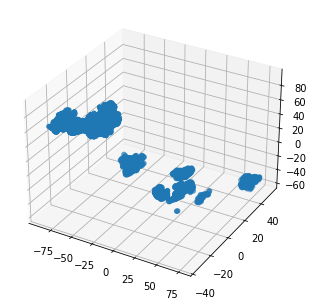

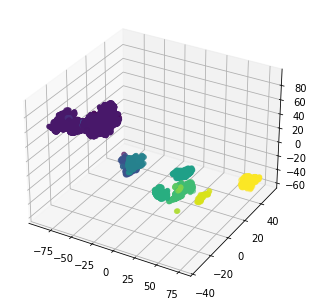

number of cluster found: 17
cluster for each point:  [ 0  0  0 ... 15 15 15]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

data = b.numpy()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.view_init()
plt.show()

model = DBSCAN(eps=2.5, min_samples=2)
model.fit_predict(data)
pred = model.fit_predict(data)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:,0], data[:,1], data[:,2], c=model.labels_)
ax.view_init()
plt.show()

print("number of cluster found: {}".format(len(set(model.labels_))))
print('cluster for each point: ', model.labels_)

In [19]:
norm_label = (model.labels_-min(model.labels_))/(max(model.labels_)-min(model.labels_))
view = show_pointcloud(target_pdb, b, norm_label)
view

2023-03-07 14:52:06 - pdbparser <INFO> All records successfully exported to 'pointcloud.pdb'


NGLWidget()

In [24]:
print(len(a), len(b), len(model.labels_))

47403 5882 5882


In [25]:
aaa = masked_coord
bbb = aaa.abs().sum(dim=1).bool()
# bb = torch.ones(len(b)) ## making psudo labels for presentation
bbb

tensor([False, False, False,  ..., False, False, False])

In [26]:
len(bbb)

47403

In [27]:
mask = bbb

In [28]:
Y = torch.where(mask == True)[0].long()
Y

tensor([   67,    70,   139,  ..., 47049, 47054, 47056])

In [29]:
X = torch.tensor(model.labels_).long()
X

tensor([ 0,  0,  0,  ..., 15, 15, 15])

In [30]:
mask_all = torch.zeros(len(mask)).long()
mask_all[Y] = X

# Filtering based on pLDDT and its impact on the final results

In [192]:
import numpy as np
import Bio.PDB as bpdb
from Bio.PDB import PDBParser

def get_bfactors(path):
    parser = PDBParser()
    structure = parser.get_structure('', path)
    residue2bfactor = {}
    for res in structure.get_residues():
        residue2bfactor[res.id[1]] = np.mean([at.bfactor for at in res.get_atoms()])
    return residue2bfactor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

acc2residue2bfactor = {}

class ResSelect(bpdb.Select):
    def accept_residue(self, res):
        if res.id[1] in remove_index:
            return False
        else:
            return True

for item in data:
    pdb = item['acc']
    path = f'{pdb_data}/{pdb}.pdb'
    residue2bfactor = get_bfactors(path)

    remove_index = []
    for item in residue2bfactor:
        if residue2bfactor[item] < 60:
            remove_index.append(item)
            
    s = bpdb.PDBParser().get_structure('temp', path)
    io = bpdb.PDBIO()
    io.set_structure(s)
    io.save(pdb+'_cropped.pdb', ResSelect())

# Calculate Concave or Convex per binding site

In [31]:
import open3d as o3d
import trimesh
import pymesh
import numpy as np

In [114]:
## Get the coordinates for one binding site; class=1
## The easiest way perhaps is to calculate residues for binding site class=1 and then see if the coordinates 
## of those residues support a concave or convex?
# atom_coords, atom_types_array, residue2coords, residue_number = load_structure(target_pdb)
cluster = torch.where(mask_all==3)
cluster_coords = coord[cluster[0]]
cluster_normals = normal[cluster[0]]
print(len(normal), len(cluster[0]), len(cluster_normals), len(cluster_coords))

47403 617 617 617


In [115]:
vertex = cluster_coords
vertex_normals = cluster_normals

In [116]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(vertex))
# pcd.estimate_normals()
pcd.normals = o3d.utility.Vector3dVector(cluster_normals.numpy())

# estimate radius for rolling ball
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 1.5 * avg_dist   

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
           pcd,
           o3d.utility.DoubleVector([radius, radius * 2]))

# create the triangular mesh with the vertices and faces from open3d
tri_mesh = trimesh.Trimesh(np.asarray(mesh.vertices), np.asarray(mesh.triangles),
                          vertex_normals=np.asarray(mesh.vertex_normals))

trimesh.convex.is_convex(tri_mesh)

False

In [117]:
print(tri_mesh)
tri_mesh.show()

<trimesh.Trimesh(vertices.shape=(607, 3), faces.shape=(1092, 3))>


In [118]:
# trimesh.convex.hull_points(tri_mesh)

In [119]:
convex_tri = trimesh.convex.convex_hull(tri_mesh)

In [120]:
convex_tri.show()

In [121]:
print(convex_tri)

<trimesh.Trimesh(vertices.shape=(48, 3), faces.shape=(92, 3))>


## testing the PlanarityIfaces plot

In [122]:
## using the Principal Component Analysis (PCA) to check if a 3D surface is flat (if it's a plane/line)

from sklearn import decomposition

def isPlaneLine(XYZ):

#     XYZ is n x 3 metrix storing xyz coordinates of n points
#     It uses PCA to check the dimensionality of the XYZ
#     th is the threshold, the smaller, the more strict for being 
#     planar/linearity

#     return 0 ==> randomly distributed
#     return 1 ==> plane
#     return 2 ==> line

    th = 1e-2

    pca = decomposition.PCA(n_components=3)
    pca.fit(XYZ)
    pca_r = pca.explained_variance_ratio_
    t = np.where(pca_r < th)

    return t[0].shape[0], pca_r

In [123]:
isPlaneLine(cluster_coords)

(0, array([0.67397502, 0.28516467, 0.04086031]))

In [321]:
## We can coclude lower variance in the 3rd dimension means flattness somehow. If an interface has low variance on
## the 3rd dimension, we can consider it as flat.
## A good example to represent is num=31 and cluster=2; the result for this is [0.64010858, 0.31447538, 0.04541605]
## Showing very low variance on the 3rd dimansion, meaning the flattness of the binding interface.

## Another example is num=32 and cluster=1. the result is [0.53230224, 0.41165319, 0.05604458]